In [33]:
import pandas as pd
import nltk
import json  
import sys  

import seaborn as sns  
import matplotlib.pyplot as plt  

from nltk.stem.snowball import EnglishStemmer
import plotly.express as px  
import numpy as np
# nltk.download('punkt')
# nltk.download('stopwords')



## Recupérer et explorer les données

La première chose que je fais est de lire mon fichier d'entrée, lire la colonne description et rajouter deux colonnes:
- word_count > Compte le nombre total de mot dans la colonne description
- unique_word_count > Compte le nombre unique de mot dans la colonne description

J'affiche ensuite les 20 produits qui ont le plus de mots et je rajoute le nombre de mot unique.

In [3]:
df = pd.read_csv("./../input/flipkart_com-ecommerce_sample_1050.csv")

In [4]:
print("Shape is", df.shape)
df.head()

Shape is (1050, 15)


,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa..."


In [5]:
df = df[["product_name","product_category_tree", "description"]]
df.head()

,product_name,product_category_tree,description
0,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",Key Features of Elegance Polyester Multicolor ...
1,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",Specifications of Sathiyas Cotton Bath Towel (...
2,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",Key Features of Eurospa Cotton Terry Face Towe...
3,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",Key Features of SANTOSH ROYAL FASHION Cotton P...
4,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",Key Features of Jaipur Print Cotton Floral Kin...


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   product_name           1050 non-null   object
 1   product_category_tree  1050 non-null   object
 2   description            1050 non-null   object
dtypes: object(3)
memory usage: 24.7+ KB


In [7]:
df.nunique()

product_name             1050
product_category_tree     642
description              1050
dtype: int64

In [8]:
df.isna().sum()

product_name             0
product_category_tree    0
description              0
dtype: int64

Je mets les categories sous forme de colonne hierachique

In [9]:
# Define a function to split and create the category columns dynamically  
def create_category_columns(row):
    json_categories = json.loads(row["product_category_tree"])
    if(len(json_categories) > 1):
        print("Categories array > 1, update the script to cover that.")
        sys.exit(1)  

    split_categories = json_categories[0].split(">>")
    
    for i, category in enumerate(split_categories):
        column_name = f"category_lvl_{i + 1}"  
        row[column_name] = category.strip().lower()
    return row

# Apply the funcion to all rows
df = df.assign(**df.apply(lambda row: create_category_columns(row), axis=1))  


In [10]:
df.head()

,product_name,product_category_tree,description,category_lvl_1,category_lvl_2,category_lvl_3,category_lvl_4,category_lvl_5,category_lvl_6,category_lvl_7
0,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",Key Features of Elegance Polyester Multicolor ...,home furnishing,curtains & accessories,curtains,elegance polyester multicolor abstract eyelet ...,NaN,NaN,NaN
1,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",Specifications of Sathiyas Cotton Bath Towel (...,baby care,baby bath & skin,baby bath towels,sathiyas baby bath towels,"sathiyas cotton bath towel (3 bath towel, red,...",NaN,NaN
2,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",Key Features of Eurospa Cotton Terry Face Towe...,baby care,baby bath & skin,baby bath towels,eurospa baby bath towels,eurospa cotton terry face towel set (20 piece ...,NaN,NaN
3,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",Key Features of SANTOSH ROYAL FASHION Cotton P...,home furnishing,bed linen,bedsheets,santosh royal fashion bedsheets,santosh royal fashion cotton printed king size...,NaN,NaN
4,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",Key Features of Jaipur Print Cotton Floral Kin...,home furnishing,bed linen,bedsheets,jaipur print bedsheets,jaipur print cotton floral king sized double b...,NaN,NaN


In [11]:
df.isna().sum()

product_name               0
product_category_tree      0
description                0
category_lvl_1             0
category_lvl_2             0
category_lvl_3             3
category_lvl_4           371
category_lvl_5           645
category_lvl_6           923
category_lvl_7           993
dtype: int64

In [12]:
df["category_lvl_3"].fillna("undefined",inplace=True)
df["category_lvl_4"].fillna("undefined",inplace=True)
df["category_lvl_5"].fillna("undefined",inplace=True)
df["category_lvl_6"].fillna("undefined",inplace=True)
df["category_lvl_7"].fillna("undefined",inplace=True)
df.isna().sum()


product_name             0
product_category_tree    0
description              0
category_lvl_1           0
category_lvl_2           0
category_lvl_3           0
category_lvl_4           0
category_lvl_5           0
category_lvl_6           0
category_lvl_7           0
dtype: int64

Je regarde la distribution de mes valeurs

In [13]:
df['category_lvl_1'].value_counts()

home furnishing               150
baby care                     150
watches                       150
home decor & festive needs    150
kitchen & dining              150
beauty and personal care      150
computers                     150
Name: category_lvl_1, dtype: int64

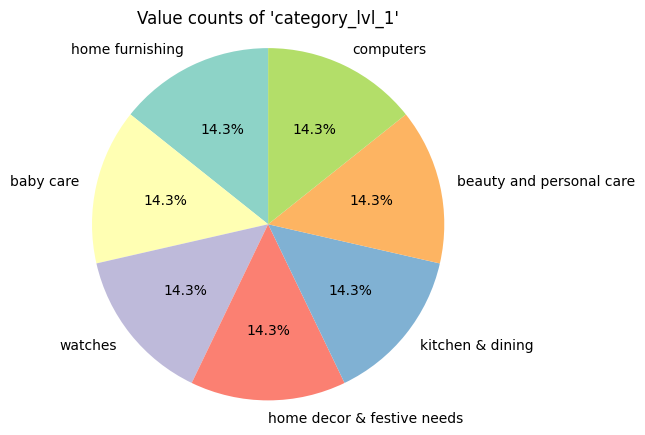

In [14]:
# Assuming 'df' is your DataFrame  
category_counts = df['category_lvl_1'].value_counts()  
  
# Set color palette from seaborn  
colors = sns.color_palette('Set3')  
  
# Create pie chart  
plt.figure(figsize=(5, 5))  
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=90, colors=colors)  
plt.axis('equal')  
plt.title("Value counts of 'category_lvl_1'")  
  
# Show the chart  
plt.show()  

La distribution est similaire pour chaque produits, j'affiche la 2e catégorie via le graphique sunburst

In [15]:
fig = px.sunburst(df, path=['category_lvl_1', 'category_lvl_2'])

fig.update_layout(  
    margin=dict(t=0, l=0, r=0, b=0),  
    width=500,  
    height=500,  
    title="Zoomable Sunburst Chart"  
)  

fig.show()

Je visualize avec Treemap pour observer la différence de rendu avec sunburst pour utiliser lors de la présentation

In [16]:
fig = px.treemap(df, path=['category_lvl_1', 'category_lvl_2', 'category_lvl_3'])  
  
fig.update_layout(  
    margin=dict(t=0, l=0, r=0, b=0),  
    width=800,  
    height=600,  
    title="Treemap Chart"  
)  
  
fig.show()

In [17]:
def analyse_one_document(row):
    text = row["description"]
    
    # Only get alphanumerical characters
    tokenizer = nltk.RegexpTokenizer(r'\w+')
    
    # Tokenize the text
    token_data = tokenizer.tokenize(text.lower())

    # Get the frequency of words
    frequency = nltk.FreqDist(token_data)
    
    # print(type(text))
    # print("Total values", len(token_data))
    # print(frequency)
    
    return (frequency, token_data)


In [18]:
for idx, item in df.iterrows():
    (frequency, token_data) = analyse_one_document(item)
    df.at[idx, 'word_count'] = len(token_data)
    df.at[idx, 'unique_word_count'] = len(frequency.keys())

In [19]:
df.head()

,product_name,product_category_tree,description,category_lvl_1,category_lvl_2,category_lvl_3,category_lvl_4,category_lvl_5,category_lvl_6,category_lvl_7,word_count,unique_word_count
0,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",Key Features of Elegance Polyester Multicolor ...,home furnishing,curtains & accessories,curtains,elegance polyester multicolor abstract eyelet ...,undefined,undefined,undefined,236.0,132.0
1,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",Specifications of Sathiyas Cotton Bath Towel (...,baby care,baby bath & skin,baby bath towels,sathiyas baby bath towels,"sathiyas cotton bath towel (3 bath towel, red,...",undefined,undefined,74.0,48.0
2,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",Key Features of Eurospa Cotton Terry Face Towe...,baby care,baby bath & skin,baby bath towels,eurospa baby bath towels,eurospa cotton terry face towel set (20 piece ...,undefined,undefined,216.0,124.0
3,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",Key Features of SANTOSH ROYAL FASHION Cotton P...,home furnishing,bed linen,bedsheets,santosh royal fashion bedsheets,santosh royal fashion cotton printed king size...,undefined,undefined,143.0,73.0
4,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",Key Features of Jaipur Print Cotton Floral Kin...,home furnishing,bed linen,bedsheets,jaipur print bedsheets,jaipur print cotton floral king sized double b...,undefined,undefined,213.0,111.0


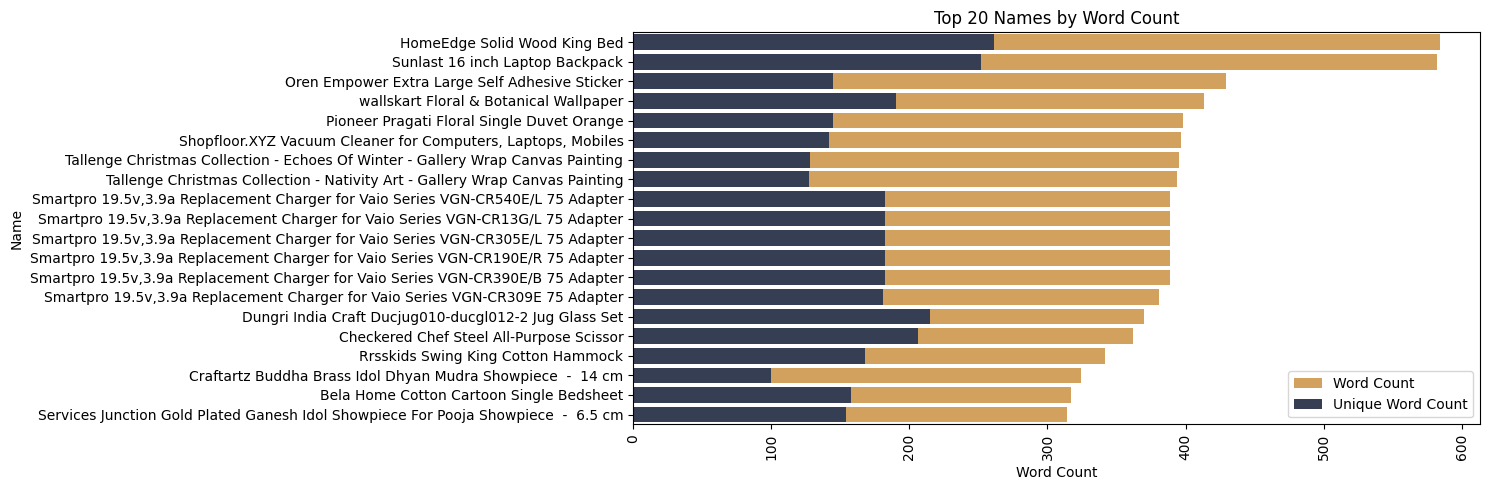

In [20]:
sorted_df = df.sort_values("word_count", ascending=False)    
top_names = sorted_df["product_name"].head(20)  
# top_names = [name[:60] + "..." if len(name) > 50 else name for name in top_names]    
  
top_word_counts = sorted_df["word_count"].head(20)  
top_unique_counts = sorted_df["unique_word_count"].head(20)  
  
plt.figure(figsize=(15, 5))  
  
# Create a horizontal barplot using seaborn    
sns.barplot(y=top_names, x=top_word_counts, orient="h",  color="#e7a44a", label="Word Count")    
sns.barplot(y=top_names, x=top_unique_counts, orient="h",  color="#313c59", label="Unique Word Count")    
  
# Set the title and axes labels    
plt.title("Top 20 Names by Word Count")    
plt.xlabel("Word Count")    
plt.ylabel("Name")    

# Rotate x-axis labels for better readability    
plt.xticks(rotation=90)
    
# Display the plot 
plt.legend()
plt.tight_layout()  
plt.show()  


Je m'interesserai qu'a la category de level 1

In [21]:
df = df.rename(columns={'category_lvl_1': 'cat'})  
df = df[["product_name","cat","description","word_count","unique_word_count"]]
df.head()

,product_name,cat,description,word_count,unique_word_count
0,Elegance Polyester Multicolor Abstract Eyelet ...,home furnishing,Key Features of Elegance Polyester Multicolor ...,236.0,132.0
1,Sathiyas Cotton Bath Towel,baby care,Specifications of Sathiyas Cotton Bath Towel (...,74.0,48.0
2,Eurospa Cotton Terry Face Towel Set,baby care,Key Features of Eurospa Cotton Terry Face Towe...,216.0,124.0
3,SANTOSH ROYAL FASHION Cotton Printed King size...,home furnishing,Key Features of SANTOSH ROYAL FASHION Cotton P...,143.0,73.0
4,Jaipur Print Cotton Floral King sized Double B...,home furnishing,Key Features of Jaipur Print Cotton Floral Kin...,213.0,111.0


J'effectue un hot hot encoding sur les categories afin de vérifier si il y a une correlation et pour future utilisations

In [22]:
df_encoded = pd.get_dummies(df, columns=["cat"])  
df_encoded.head()

,product_name,description,word_count,unique_word_count,cat_baby care,cat_beauty and personal care,cat_computers,cat_home decor & festive needs,cat_home furnishing,cat_kitchen & dining,cat_watches
0,Elegance Polyester Multicolor Abstract Eyelet ...,Key Features of Elegance Polyester Multicolor ...,236.0,132.0,0,0,0,0,1,0,0
1,Sathiyas Cotton Bath Towel,Specifications of Sathiyas Cotton Bath Towel (...,74.0,48.0,1,0,0,0,0,0,0
2,Eurospa Cotton Terry Face Towel Set,Key Features of Eurospa Cotton Terry Face Towe...,216.0,124.0,1,0,0,0,0,0,0
3,SANTOSH ROYAL FASHION Cotton Printed King size...,Key Features of SANTOSH ROYAL FASHION Cotton P...,143.0,73.0,0,0,0,0,1,0,0
4,Jaipur Print Cotton Floral King sized Double B...,Key Features of Jaipur Print Cotton Floral Kin...,213.0,111.0,0,0,0,0,1,0,0


/var/folders/x_/0z24g8110_n09vlvhxmrh0_w0000gp/T/ipykernel_17428/676038228.py:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



<Axes: >

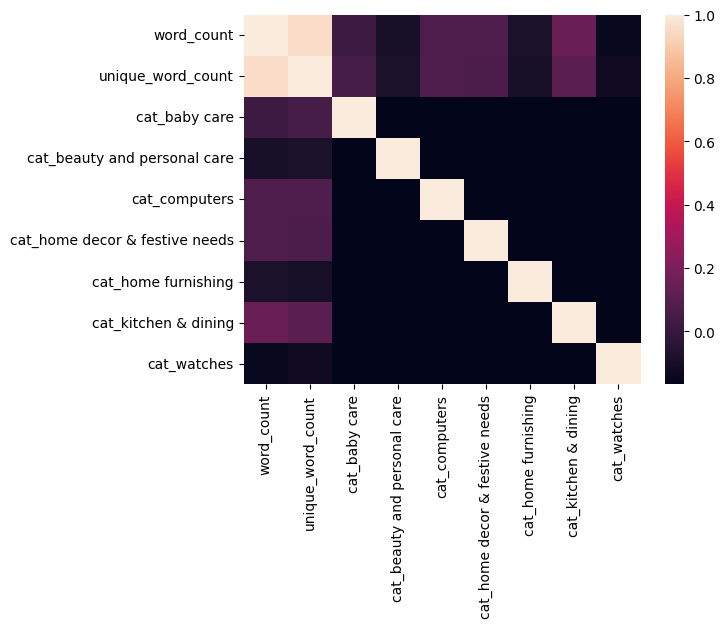

In [23]:
sns.heatmap(df_encoded.corr())

In [24]:
df.head()

,product_name,cat,description,word_count,unique_word_count
0,Elegance Polyester Multicolor Abstract Eyelet ...,home furnishing,Key Features of Elegance Polyester Multicolor ...,236.0,132.0
1,Sathiyas Cotton Bath Towel,baby care,Specifications of Sathiyas Cotton Bath Towel (...,74.0,48.0
2,Eurospa Cotton Terry Face Towel Set,baby care,Key Features of Eurospa Cotton Terry Face Towe...,216.0,124.0
3,SANTOSH ROYAL FASHION Cotton Printed King size...,home furnishing,Key Features of SANTOSH ROYAL FASHION Cotton P...,143.0,73.0
4,Jaipur Print Cotton Floral King sized Double B...,home furnishing,Key Features of Jaipur Print Cotton Floral Kin...,213.0,111.0


In [27]:
import pandas as pd  
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer  
import re  
from nltk.corpus import stopwords  
import nltk  

In [28]:
def clean_text(text):  
    # Retirer les caractères non-alphabétiques et mettre le texte en minuscule  
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A).lower()  
    # Tokenization  
    tokens = text.split()  
    # Stopwords removal  
    filtered_tokens = [token for token in tokens if token not in stopwords.words('english')]  
    # Rejoindre les mots  
    text = ' '.join(filtered_tokens)  
    return text  
  
# Appliquer la fonction de nettoyage sur la colonne description  
df['cleaned_description'] = df['description'].apply(clean_text)  

In [29]:
df.head()

,product_name,cat,description,word_count,unique_word_count,cleaned_description
0,Elegance Polyester Multicolor Abstract Eyelet ...,home furnishing,Key Features of Elegance Polyester Multicolor ...,236.0,132.0,key features elegance polyester multicolor abs...
1,Sathiyas Cotton Bath Towel,baby care,Specifications of Sathiyas Cotton Bath Towel (...,74.0,48.0,specifications sathiyas cotton bath towel bath...
2,Eurospa Cotton Terry Face Towel Set,baby care,Key Features of Eurospa Cotton Terry Face Towe...,216.0,124.0,key features eurospa cotton terry face towel s...
3,SANTOSH ROYAL FASHION Cotton Printed King size...,home furnishing,Key Features of SANTOSH ROYAL FASHION Cotton P...,143.0,73.0,key features santosh royal fashion cotton prin...
4,Jaipur Print Cotton Floral King sized Double B...,home furnishing,Key Features of Jaipur Print Cotton Floral Kin...,213.0,111.0,key features jaipur print cotton floral king s...


In [30]:
# Bag-of-words  
count_vectorizer = CountVectorizer()  
bow_matrix = count_vectorizer.fit_transform(df['cleaned_description'])  
  
# Tf-idf  
tfidf_vectorizer = TfidfVectorizer()  
tfidf_matrix = tfidf_vectorizer.fit_transform(df['cleaned_description'])  

In [34]:
from gensim.models import Word2Vec  
  
# Liste de listes de tokens pour word2vec  
tokenized_docs = df['cleaned_description'].apply(lambda x: x.split())  
  
# Formation du modèle Word2Vec (peut prendre du temps en fonction de la taille du dataset)  
word2vec_model = Word2Vec(tokenized_docs, vector_size=100, window=5, min_count=1, workers=4)  
  
# Création d'une représentation vectorielle moyenne pour chaque description  
def document_vector(doc):  
    # Supprimer les mots inconnus  
    doc = [word for word in doc if word in word2vec_model.wv.index_to_key]  
    return np.mean(word2vec_model.wv[doc], axis=0) if len(doc) > 0 else np.zeros(word2vec_model.vector_size)  
  
word2vec_features = np.vstack(tokenized_docs.apply(document_vector))  

In [37]:
# Pour BERT et USE (TensorFlow Hub est nécessaire)  
import tensorflow_hub as hub  
  
# BERT embeddings  
bert_model = hub.load("https://tfhub.dev/google/bert-en-uncased-l-12-h-128-a-2/2")  
def get_bert_embeddings(sentences):  
    # Votre fonction pour obtenir des embeddings à partir du BERT model  
    # ...  
    return bert_embeddings  
  
bert_embeddings = get_bert_embeddings(df['cleaned_description'])  
  
# # Universal Sentence Encoder embeddings  
# use_model = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")  
# use_embeddings = use_model(df['cleaned_description'])  

OSError: https://tfhub.dev/google/bert-en-uncased-l-12-h-128-a-2/2 does not appear to be a valid module.

In [39]:
from sklearn.manifold import TSNE  
  
# Prenons les features Tf-idf pour cet exemple  
# Note: Prévoir un temps de calcul suffisant pour les grands jeux de données  
tsne = TSNE(n_components=2, random_state=42)  
reduced_features = tsne.fit_transform(tfidf_matrix.toarray())  
  
# Associer les réductions de dimension avec la catégorie réelle  
reduced_df = pd.DataFrame(reduced_features, columns=['x', 'y'])  
reduced_df['cat'] = df['cat']  

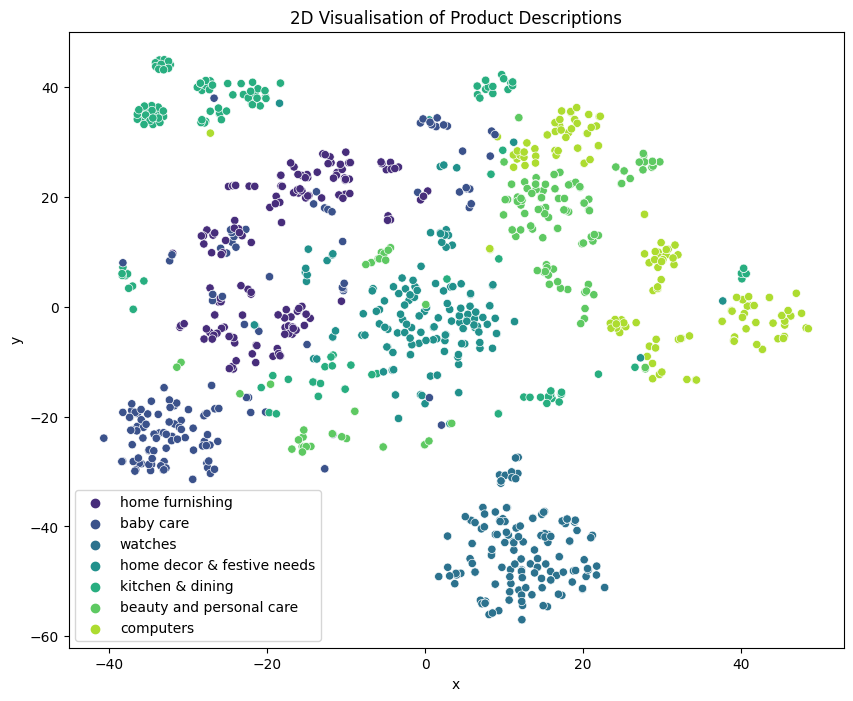

In [41]:
# Plot  
plt.figure(figsize=(10, 8))  
sns.scatterplot(x='x', y='y', hue='cat', data=reduced_df, palette='viridis')  
  
# Ajouter des légendes et des titres si nécessaire  
plt.title('2D Visualisation of Product Descriptions')  
plt.legend()  
plt.show()  

In [43]:
from sklearn.cluster import KMeans  
from sklearn.metrics import silhouette_score  
  
# Nombre de clusters à définir, pourrait être égal au nombre de catégories uniques  
num_clusters = df['cat'].nunique()  
kmeans = KMeans(n_clusters=num_clusters, random_state=42).fit(reduced_features)  
  
# score de silhouette  
silhouette = silhouette_score(reduced_features, kmeans.labels_)  
  
print(f"Le score de silhouette est de : {silhouette}")  

Le score de silhouette est de : 0.5047770142555237


/Users/m/.pyenv/versions/3.10.12/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

